In [69]:
import pandas as pd
import QuantLib as ql
import seaborn as sns

# Read the yield curve data
yield_curve_df = pd.read_excel('../data/raw/curves/CAD/cad_03212013.xlsx')
yield_curve_df2 = pd.read_excel('../data/raw/curves/CAD/cad_09202013.xlsx')

evaluation_date = ql.Date(21, 3, 2013)
ql.Settings.instance().evaluationDate = evaluation_date

# Calculate the next IMM date
next_imm_date = ql.IMM.nextDate(evaluation_date)

# Build the yield curve
helpers = []
for index, row in yield_curve_df.iterrows():
    rate = row['Yield']/100
    tenor = ql.Period(row['Tenor'])
    day_count = ql.Actual365Fixed()

    fixed_leg_frequency = ql.Semiannual
    fixed_leg_adjustment = ql.ModifiedFollowing
    fixed_leg_daycount = ql.Thirty360(ql.Thirty360.BondBasis)

    if "Index" in row["Description"]:
        # Use Deposit Rate Helpers
        helpers.append(ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                                            tenor, 0,
                                            ql.Canada(),
                                            ql.ModifiedFollowing, False,
                                            day_count))
    elif "Comdty" in row["Description"]:
        # Use Futures Rate Helpers
        price = 100 - (rate*100)  # Convert quote to price
        helpers.append(ql.FuturesRateHelper(price, next_imm_date, ql.Cdor(tenor)))
    elif "CDS" in row["Description"]:
        # Use swap rate helpers
        swap_rate_helper = ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                                             tenor,
                                             ql.Canada(),
                                             fixed_leg_frequency,
                                             fixed_leg_adjustment,
                                             fixed_leg_daycount,
                                             ql.Cdor(ql.Period('3M')))
        helpers.append(swap_rate_helper)

# Create the yield curve
curve = ql.PiecewiseFlatForward(evaluation_date, helpers, ql.Actual365Fixed())


In [70]:
# Swap start and end dates
effective_date = ql.Date(30, 5, 2014)
maturity_date = ql.Date(30, 5, 2016)

fixed_leg_frequency = ql.Semiannual
fixed_leg_adjustment = ql.ModifiedFollowing
fixed_leg_daycount = ql.Thirty360(ql.Thirty360.BondBasis)

floating_leg_frequency = ql.Semiannual
floating_leg_adjustment = ql.ModifiedFollowing
floating_leg_daycount = ql.Actual360()

# Fixed and floating leg payment schedules
fixed_schedule = ql.Schedule(effective_date, maturity_date, ql.Period(fixed_leg_frequency),
                            ql.Canada(), fixed_leg_adjustment, fixed_leg_adjustment,
                            ql.DateGeneration.Forward, False)

floating_schedule = ql.Schedule(effective_date, maturity_date, ql.Period(floating_leg_frequency),
                               ql.Canada(), floating_leg_adjustment, floating_leg_adjustment,
                               ql.DateGeneration.Forward, False)

# Create the fixed and floating legs of the swap
fixed_rate = 0.025  # Assuming a fixed rate of 2.5% for the fixed leg
ibor_index = ql.Cdor(ql.Period('3M'), ql.YieldTermStructureHandle(curve))
# Create the swap instrument
swap = ql.VanillaSwap(ql.VanillaSwap.Payer, 100000000, fixed_schedule, fixed_rate, fixed_leg_daycount,
                      floating_schedule, ibor_index, 0, floating_leg_daycount)

# Price the swap using the yield curve
discount_curve_handle = ql.YieldTermStructureHandle(curve)
swap_engine = ql.DiscountingSwapEngine(discount_curve_handle)
swap.setPricingEngine(swap_engine)

# Calculate the swap's net present value (NPV)
swap_npv = swap.NPV()
swap_fair_value = swap.fairRate()*100
print("Swap NPV: {:.2f}".format(swap_npv))
print("Swap Fair Value: {:.2f}".format(swap_fair_value))

Swap NPV: -1763264.70
Swap Fair Value: 1.59


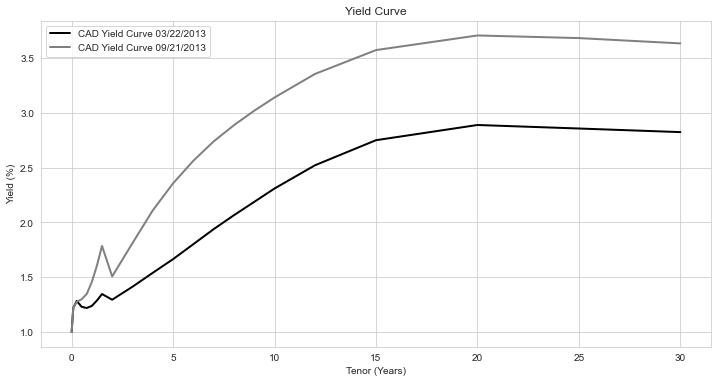

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate months from tenors
def period_in_years(period):
    units = period.units()
    if units == ql.Days:
        denominator = 365
    elif units == ql.Weeks:
        denominator = 52
    elif units == ql.Months:
        denominator = 12
    elif units == ql.Years:
        denominator = 1
    return period.length() / denominator

yield_curve_df['Years'] = yield_curve_df['Tenor'].apply(lambda x: period_in_years(ql.Period(x)))
yield_curve_df2['Years'] = yield_curve_df2['Tenor'].apply(lambda x: period_in_years(ql.Period(x)))

sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '-'})
plt.figure(figsize=(12, 6))
plot = sns.lineplot(data=yield_curve_df, x='Years', y='Yield', linewidth=2, color='black', label='CAD Yield Curve 03/22/2013')
plot = sns.lineplot(data=yield_curve_df2, x='Years', y='Yield', linewidth=2, color='gray', label='CAD Yield Curve 09/21/2013')
plot.set(xlabel='Tenor (Years)', ylabel='Yield (%)')
plt.title('Yield Curve')
plt.show()